**Model Skeleton**

Click [here](https://docs.google.com/document/d/1v8xBxDOmItnDbMlbNnb4KsY-F7_jp1F9RJ-aIMr2KHA/edit?usp=sharing) for a detailed description of the purpose of every code chunk

**Make sure to run this script on Google Colab to ensure compatability with Drive mounting**

**0) Import Dependencies and Mount Drive**

In [ ]:
# ─── Standard Library ───────────────────────────────────────────────────────
import os
import re
import glob
import time
import struct
import random
import shutil
from datetime import datetime
from collections import Counter, OrderedDict
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path

# ─── Data Handling ──────────────────────────────────────────────────────────
import numpy as np
import pandas as pd

# ─── Visualization ──────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Machine Learning & PyTorch ─────────────────────────────────────────────
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader, Sampler, random_split
import torch.backends.cudnn as cudnn
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# ─── Computer Vision ────────────────────────────────────────────────────────
from torchvision import datasets, transforms, models
from torchvision.transforms.functional import pad
from torchvision.utils import save_image
from PIL import Image, UnidentifiedImageError
import cv2
from skimage import io, color
import timm  # For accessing pretrained models beyond torchvision

# ─── Metrics & Evaluation ───────────────────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

# ─── Progress Monitoring ────────────────────────────────────────────────────
from tqdm.auto import tqdm
import os, subprocess


import os
import shutil
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
from PIL import Image
import pandas as pd
import re
import time
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import struct
import numpy as np
from torch.nn.functional import pad
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from collections import Counter


# ─── Reproducibility ────────────────────────────────────────────────────────
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# Connect to Google Drive - remember to make a shortcut of the "Patches" folder to "My Drive"
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [3]:
# 0. Variables from your unzipping script
# These should match what you used for unzipping
zip_path = '/content/drive/MyDrive/Patches_Apr27.zip' # Source ZIP on Drive
extract_dir = '/content/Patches_Apr27' # Local extraction directory

In [4]:
import os
from google.colab import drive
import shutil

# 1. Mount Google Drive (skip remount warning)
drive.mount('/content/drive')

# 2. Paths
zip_path = '/content/drive/MyDrive/Patches_Apr27.zip'
extract_dir = '/content/Patches_Apr27'

# 3. Remove any previous partial extraction
if os.path.exists(extract_dir):
    print("🗑️ Removing old extract folder...")
    shutil.rmtree(extract_dir)

# 4. Re-unzip using shell unzip (handles large files better)
print("📦 Re-unzipping ZIP to /content...")
!unzip -q -o "$zip_path" -d "/content"
print("✅ Unzipping complete.")

# 5. Count image files
image_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}
image_files = []
for root, _, files in os.walk(extract_dir):
    for f in files:
        if os.path.splitext(f)[1].lower() in image_exts:
            image_files.append(os.path.join(root, f))

print(f"📸 Total image files after fresh unzip: {len(image_files)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Re-unzipping ZIP to /content...
✅ Unzipping complete.
📸 Total image files after fresh unzip: 73301


**1. Configuration**

*Contains everything we can change about the model besides the model itself. The only other part of the code you should need to modify is in the section "Define Your Model and Train"*

- Paths to our data (**update these paths with the paths from your own drive**)
    - drive_image_folder (this is the drive folder with all images)
    - label_csv (this is the path with true labels "case_grade_match.csv")
    - meta_csv_full_scan (this is the path where the metadata is saved)

- Data to train on (**update these params with the cases you want to train on**)
    - train_cases
    - test_cases
    - validation_cases

- Filtering Parameters (**update these params with the stains and sizes you want to train on**)
    - target_stain
    - min_image_size
    - max_image_size
- Hyperparameters
    - lr (learning rate)
    - num_epochs (number of epochs)
    - batch_size

- Other Parameters
    - force_rebuild_metadata_full
        - This will rebuild the metadata each time
        - **Only set to false if you have not changed any other parameters** (meaning that your filtering params and data to train on have not changed)

    - Device
        - Controls what hardware (GPU vs. CPU etc) we use (defualt GPU)
    - num_workers
        - Param for the data loader. If num_workers > 0, we load + preprocess data in parallel with model training.
        - currently not in use bc data loading is fast




In [5]:
#Create train, test, and val lists

train_test_val_df = pd.read_csv("/content/drive/MyDrive/ML model comparison - Train-test split.csv")

train_list = train_test_val_df[train_test_val_df.Data == "Train"].Case.to_list()
test_list = train_test_val_df[train_test_val_df.Data == "Test"].Case.to_list()
val_list = train_test_val_df[train_test_val_df.Data == "Validate"].Case.to_list()

In [6]:
# ─── 1) CONFIG (Updated for Full Scan & Local Paths) ──────────────────────────────────
CONFIG = {
    #MODIFIED: Changed from 'drive_image_folder' and updated path
    'local_image_folder': extract_dir,  # read directly from /content/Patches_Apr27
    'label_csv': "/content/drive/MyDrive/case_grade_match.csv", # Assuming labels still on Drive
    'meta_csv_full_scan': "/content/metadata_full_scan_local_paths.csv",  # Explicitly local
    'batch_size': 2,
    'num_workers': 4, # Adjusted for potentially faster local I/O
    'lr': 1e-3,
    'num_epochs': 3, # Keep as 1 for a quick test, adjust as needed
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'train_cases': train_list,
    'test_cases': test_list,
    'validation_cases': val_list,
    # 'num_workers': 8, # You have num_workers defined twice, choose one. Using 4 from above.
    'force_rebuild_metadata_full': True, # Set to True for the first run with new paths
    'min_image_size': 50,
    'max_image_size': 100000,
    'target_stain': 'sox10'
}

# Combine all cases from train/val/test for the initial full metadata scan
all_cases_for_scan = set(CONFIG['train_cases'] + CONFIG['test_cases'] + CONFIG['validation_cases'])
print(f"Cases included in initial full metadata scan: {len(all_cases_for_scan)}")
print(f"Target stain for this run: {CONFIG['target_stain']}")
print(f"🖼️ Image data will be read from: {CONFIG['local_image_folder']}") # Verify local path
if CONFIG['force_rebuild_metadata_full']:
    print("❗ Metadata will be rebuilt.")
torch.backends.cudnn.benchmark = True


Cases included in initial full metadata scan: 77
Target stain for this run: sox10
🖼️ Image data will be read from: /content/Patches_Apr27
❗ Metadata will be rebuilt.


**Note** – the ```n_buckets``` input for our bucketing logic is not included in the CONFIG. You'll have to manually change it the code chunk where we create the boundaries and data loaders (see below in section 6). The default is just to keep ```n_buckets``` = number of batches.

**2) Build Metadata**

Uses 3 code chunks

1) Helper functions: help optimize build_metadata function

2) Build metadata function: creates metadata

3) Calling build metadata

In [7]:
# ─── 1) HELPERS ──────────────────────────────────────────────────────────────
# Regex for filenames like "case_001_match_…png" or "case_12_unmatched_…png"
case_pat = re.compile(r'case_0*(\d+)_(?:match|unmatched)_', re.IGNORECASE)

def fast_scan(root, max_retries=3, backoff=1.5):
    """
    Efficiently and safely scans a directory tree for .png files.
    Automatically retries failed directory reads (useful for Google Drive in Colab).
    Args:
        root (str): Root directory to scan.
        max_retries (int): Max retries per failed directory.
        backoff (float): Base multiplier for exponential delay between retries.
    """
    def scan_dir(path, retries=0):
        try:
            # Check if path exists before scanning
            if not os.path.exists(path):
                print(f"⚠️ Directory not found: {path}. Skipping scan for this path.")
                return [] # Return empty iterator if path doesn't exist

            for entry in os.scandir(path):
                if entry.is_file() and entry.name.lower().endswith('.png'):
                    yield entry.path
                elif entry.is_dir():
                    yield from scan_dir(entry.path) # Recursive call
        except OSError as e:
            if retries < max_retries:
                wait = backoff ** retries
                print(f"⚠️  I/O error on {path} (attempt {retries+1}/{max_retries}). Retrying in {wait:.1f}s...")
                time.sleep(wait)
                yield from scan_dir(path, retries + 1)
            else:
                print(f"❌ Skipping {path} after {max_retries} failed attempts due to OSError: {e}")
        except FileNotFoundError: # Explicitly handle FileNotFoundError during scandir
             print(f"⚠️ Directory not found during scandir: {path}. Skipping.")
             return []
    return scan_dir(root)

In [8]:
# ─── 2) OPTIMIZED METADATA BUILDER ───────────────────────────────────────────
def build_metadata(image_folder, all_cases, meta_csv, stain,
                   force_rebuild=False, min_width=0, max_width=float('inf'),
                   num_workers=4):
    """
    Builds or loads a filtered metadata DataFrame:
      - only cases in `all_cases`
      - only files whose paths contain `stain`
      - only images with width/height in (min_width,max_width) or unknown dims (-1)
    """
    # Try loading existing CSV
    if os.path.exists(meta_csv) and not force_rebuild:
        try:
            df = pd.read_csv(meta_csv)
            required = {'path','case_number','stain','width','height'}
            if required.issubset(df.columns):
                # apply filters
                df = df[df.case_number.isin(all_cases)]
                # Ensure width/height are numeric for filtering, coerce errors to NaN then fill with -1
                df['width'] = pd.to_numeric(df['width'], errors='coerce').fillna(-1).astype(int)
                df['height'] = pd.to_numeric(df['height'], errors='coerce').fillna(-1).astype(int)

                df = df[((df.width  >= min_width) & (df.width  <= max_width)) | (df.width  == -1)] # inclusive min/max
                df = df[df.stain.str.lower() == stain.lower()]
                print(f"Loaded & filtered {len(df)} rows from {meta_csv}")
                if not df.empty:
                     # CRITICAL: Verify that paths are what you expect (local paths)
                    print(f"Example path from loaded metadata: {df['path'].iloc[0]}")
                return df
        except Exception as e:
            print(f"❗ Error loading or filtering {meta_csv}: {e}; rebuilding…")

    # Full rescan
    print(f"🔍 Scanning {image_folder} for stain='{stain}'…")
    if not os.path.exists(image_folder):
        print(f"❌ Error: Image folder for scanning does not exist: {image_folder}")
        return pd.DataFrame(columns=['path','case_number','stain','width','height'])

    files = list(fast_scan(image_folder))
    if not files:
        print(f"⚠️  No PNG files found in {image_folder} or its subdirectories.")
        return pd.DataFrame(columns=['path','case_number','stain','width','height'])
    print(f"Found {len(files)} PNG files during scan.")

    def proc(p):
        # p will be a full local path like /content/Patches_Apr27/case_001_match_xyz.png
        m = case_pat.search(os.path.basename(p))
        if not m:
            return None
        cid = int(m.group(1))

        if cid not in all_cases:
            return None
        if stain.lower() not in p.lower(): # Simple substring check for stain in path
            return None

        w, h = -1, -1
        try:
            with open(p,'rb') as f:
                hdr = f.read(24)
            if hdr.startswith(b'\x89PNG\r\n\x1a\n') and hdr[12:16] == b'IHDR':
                w = struct.unpack('>I',hdr[16:20])[0]
                h = struct.unpack('>I',hdr[20:24])[0]
            else: # Fallback if not standard PNG header or IHDR not where expected
                with Image.open(p) as img:
                    w, h = img.size
        except Exception as e:
            # print(f"Warning: Could not get dimensions for {p}: {e}")
            pass # Keep w,h as -1

        # size filter (inclusive)
        if w != -1 and not (min_width <= w <= max_width and min_width <= h <= max_width):
            return None

        return {
            'path': p, # This path is now a local path
            'case_number': cid,
            'stain': stain.lower(), # Store the target stain
            'width': w,
            'height': h
        }

    with ThreadPoolExecutor(max_workers=num_workers) as exe:
        rows = list(tqdm(exe.map(proc, files), total=len(files), desc="Processing files"))

    df = pd.DataFrame([r for r in rows if r])
    if df.empty:
        print(f"⚠️  No metadata built for stain='{stain}' after filtering. Check scan and filters.")
        return df

    df.to_csv(meta_csv, index=False)
    print(f"✅ Built & saved {len(df)} rows to {meta_csv}")
    if not df.empty:
        print(f"Example path from NEWLY BUILT metadata: {df['path'].iloc[0]}")
    return df

In [9]:
# create metadata
full_meta_df = build_metadata(
    image_folder=CONFIG['local_image_folder'], # MODIFIED: Use the local image folder
    all_cases=all_cases_for_scan,
    meta_csv=CONFIG['meta_csv_full_scan'],
    stain=CONFIG['target_stain'],
    force_rebuild=CONFIG['force_rebuild_metadata_full'],
    min_width=CONFIG['min_image_size'],
    max_width=CONFIG['max_image_size'],
    num_workers=CONFIG['num_workers']
)

# Ensure full_meta_df is not empty before proceeding
if full_meta_df.empty:
    print("❌ Metadata DataFrame is empty. Cannot proceed. Please check previous steps, especially the image path and scan.")
    # exit() # Or handle appropriately

🔍 Scanning /content/Patches_Apr27 for stain='sox10'…
Found 73301 PNG files during scan.


Processing files: 100%|██████████| 73301/73301 [00:01<00:00, 41981.09it/s]

✅ Built & saved 15614 rows to /content/metadata_full_scan_local_paths.csv
Example path from NEWLY BUILT metadata: /content/Patches_Apr27/case_066_match_1_sox10_patch79.png


In [10]:
save_path = '/content/drive/MyDrive/sox10_meta.csv'
full_meta_df.to_csv(save_path, index=False)

print(f"✅ Metadata saved to {save_path}")

✅ Metadata saved to /content/drive/MyDrive/sox10_meta.csv


**Note**: You might get an I/O error upon running the create metadata code chunk. This is because of occasional timeout errors with connecting to Google Drive given how large our patches folder is. Rerun the code chunks until now if you face this error, and it should work after a few retries (this is assuming you haven't messed with the CONFIG settings or metadata file). You may also want to try restarting the runtime and re-running all the code chunks.

**3. Load Labels**
- This loads in the class labels and creates a labels map

In [ ]:
# ─── 3) LOAD LABELS_MAP ─────────────────────────────────────────────────────
if not os.path.exists(CONFIG['label_csv']):
    raise FileNotFoundError(f"Labels CSV missing: {CONFIG['label_csv']}")
labels_df = (
    pd.read_csv(CONFIG['label_csv'])
      .drop(index=64, errors='ignore')
      .reset_index(drop=True)
)
labels_map = {
    int(r.Case): (0 if r.Class == 1 else 1)
    for _, r in labels_df.iterrows()
}
print(f"🗺️  Created labels_map for {len(labels_map)} cases")


🗺️  Created labels_map for 105 cases


**4. Define Transforms**

- **Important** The mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] values are specific to models that are pretrained on ImageNet. If your model was pretrained on a different dataset, your mean and std values should be calculated based on the properties of that dataset
- Adjust the transformations as per requirements of your specific model

In [ ]:
# ─── TRANSFORMS (Adaptive Pooling Approach) ───────────────────────────
# These transforms are applied to individual images by the Dataset's __getitem__.

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # Example augmentation
    #transforms.RandomRotation(15), # Example augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05), # Example augmentation
    transforms.ToTensor(), # Converts PIL Image to Tensor and scales [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet standard deviation
])

eval_transform = transforms.Compose([
    transforms.ToTensor(), # Converts PIL Image to Tensor and scales [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet standard deviation
])

**5) Create Dataset Objects for Train, Test, and Validation**

1) Define dataset class

2) Create datasets for train, test, and val

In [ ]:
# --- Corrected PatchDataset Class ---
class PatchDataset(Dataset):
    def __init__(self, meta_df, labels_map, transform=None):
        """
        Args:
            meta_df (pd.DataFrame): Metadata DataFrame containing columns: path, case_number, stain, width, height
            labels_map (dict): Mapping of case number to class label
            transform (callable): Optional transform to apply to each image
        """
        self.meta = meta_df

        # Build list of (path, label) from filtered metadata
        # THIS LINE MUST EXECUTE BEFORE you try to access self.samples
        self.samples = [
            (row.path, labels_map[int(row.case_number)])
            for row in self.meta.itertuples()
            if int(row.case_number) in labels_map
        ]
        self.transform = transform

        # NOW it's safe to print the length of self.samples
        print(f"DEBUG: Dataset initialized with {len(self.samples)} total samples.")

    def __len__(self) -> int:
        return len(self.samples)
    def __getitem__(self, idx: int):
            # The IndexError traceback means this 'idx' is out of range for 'self.samples'
            # The primary fix for that is ensuring __len__ and __init__ are correct
            # This print will help verify if it's still being called with bad indices
            # print(f"DEBUG: __getitem__ called with idx = {idx}. len(self.samples) = {len(self.samples)}")

            # Ensure idx is within bounds. If this check triggers, the problem is in __len__ or DataLoader
            if not (0 <= idx < len(self.samples)):
                raise IndexError(f"__getitem__ called with invalid index {idx}. Valid range is [0, {len(self.samples)-1}]")

            path, label = self.samples[idx] # This is the line that errors

            try:
                img = Image.open(path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                cid = int(case_pat.search(os.path.basename(path)).group(1))
                return img, label, cid
            except Exception as e:
                # --- CRITICAL FIX HERE ---
                # DO NOT return None. Instead, log the error and re-raise it.
                # This will force the DataLoader to stop at the first genuinely problematic image file.
                print(f"ERROR: Failed to load or process image at index {idx} from path: '{path}'. Error: {e}")
                raise # Re-raise the exception to stop execution and debug the root cause

In [ ]:
# --- Splitting metadata and creating datasets ---
# (Small modifications to handle potentially empty full_meta_df)
if not full_meta_df.empty:
    train_meta = full_meta_df[full_meta_df['case_number'].isin(CONFIG['train_cases'])].reset_index(drop=True)
    val_meta   = full_meta_df[full_meta_df['case_number'].isin(CONFIG['validation_cases'])].reset_index(drop=True)
    test_meta  = full_meta_df[full_meta_df['case_number'].isin(CONFIG['test_cases'])].reset_index(drop=True)

    if train_meta.empty or val_meta.empty or test_meta.empty:
        print("⚠️ One or more metadata splits (train/val/test) are empty. Check case lists and filtering.")

    train_dataset = PatchDataset(train_meta, labels_map, transform=train_transform)
    val_dataset   = PatchDataset(val_meta, labels_map, transform=eval_transform)
    test_dataset  = PatchDataset(test_meta, labels_map, transform=eval_transform)

    print(f"✅ Train patches: {len(train_dataset)}")
    print(f"✅ Val patches: {len(val_dataset)}") # Fixed typo from Test to Val
    print(f"✅ Test patches: {len(test_dataset)}")
else:
    print("❌ Skipping dataset creation due to empty full_meta_df.")
    # Initialize empty datasets or handle error
    train_dataset, val_dataset, test_dataset = None, None, None

DEBUG: Dataset initialized with 8141 total samples.
DEBUG: Dataset initialized with 3054 total samples.
DEBUG: Dataset initialized with 3416 total samples.
✅ Train patches: 8141
✅ Val patches: 3054
✅ Test patches: 3416


**6) Data Loader and Helper Functions**


There are 3 code chunks for 3 different helper functions:
- BucketSampler: function behind our bucketing logic. It will group indices of similar-sized images together
- make_boundaries_for_buckets: will calculate and define the actual size boundaries for our batches
- collate_fn_pad: collate functions are used by the DataLoader object to group individual samples into a batch. Our custom function also performs the padding operation within each batch

**Bucketing logic**: Because we have to pad images up to the size of the largest image within each batch, we want to make sure that images within the same batch are of similar sizes. To do this, we will first calculate the total_number_of_batches that will be used per epoch (total images/batch size). Then we will separate the images by width into total_number_of_batches number of bins (e.g. if total_number_of_batches = 40, then there will be 40 bins). Then each of these bins will be a batch and sent separately to be trained on — thus images within the same batch are of very similar sizes and the amount of padding needed is very negligible).

In [ ]:

# ─── HELPER: BUCKET BATCH SAMPLER ─────────────────────────────────────
# This Sampler is responsible for the "bucketing" logic.
# It groups indices of similar-sized images together.
class BucketBatchSampler(Sampler):
    """
    Samples batches by grouping indices into buckets based on data source sizes.
    Batches are created from indices within the same bucket.
    """
    def __init__(self, data_source_sizes, batch_size, boundaries, shuffle=True):
        """
        Args:
            data_source_sizes (list): List of sizes (e.g., max dimension after resize) for each item.
            batch_size (int): The desired batch size.
            boundaries (list): A sorted list of size thresholds defining the buckets.
                               An item with size S falls into bucket i if boundaries[i-1] < S <= boundaries[i].
            shuffle (bool): Whether to shuffle indices within buckets and the order of batches.
        """
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Create buckets based on boundaries
        bucket_indices = {i: [] for i in range(len(boundaries) + 1)}
        for idx, size in enumerate(data_source_sizes):
            # Determine which bucket the size falls into
            bucket_num = sum(size > b for b in boundaries)
            bucket_indices[bucket_num].append(idx)

        self.batches = []
        # Create batches from indices within each bucket
        for bucket_num in sorted(bucket_indices.keys()):
            indices_in_bucket = bucket_indices[bucket_num]
            if self.shuffle:
                np.random.shuffle(indices_in_bucket)

            for i in range(0, len(indices_in_bucket), batch_size):
                batch = indices_in_bucket[i:i+batch_size]
                if len(batch) > 0:
                    self.batches.append(batch)

        if self.shuffle:
            np.random.shuffle(self.batches)

    def __iter__(self):
        return iter(self.batches)

    def __len__(self):
        return len(self.batches)

In [ ]:
# ─── HELPER: MAKE BUCKET BOUNDARIES (Optimized for N Batches) ─────────
# This helper is used to calculate the boundaries for the buckets.
def make_boundaries_for_buckets(sizes, n_buckets):
    """
    Creates bucket boundaries such that the data is split into approximately
    n_buckets groups of equal size based on the sorted 'sizes'.
    Returns n_buckets - 1 boundaries.
    """
    #if not sizes or n_buckets <= 1:
    if sizes is None or len(sizes) == 0 or n_buckets <= 1:
        return []

    # Convert to pandas Series to use quantile/percentile efficiently
    sizes_series = pd.Series(sizes)
    total_items = len(sizes_series)
    boundaries = []

    # Calculate quantiles to define boundaries
    # We need n_buckets - 1 division points
    quantiles = [(i / n_buckets) for i in range(1, n_buckets)]

    # Calculate the boundary values using quantiles
    # Handle potential errors if quantile calculation fails (e.g., not enough unique sizes)
    try:
        bounds = sizes_series.quantile(quantiles).tolist()
    except Exception:
        # Fallback to simpler percentile calculation if quantile fails
        qs = [100 * i / n_buckets for i in range(1, n_buckets)]
        bounds = np.percentile(sizes, qs).tolist()


    # Ensure boundaries are unique, sorted, and integer
    return sorted(list(set(int(b) for b in bounds)))

In [ ]:

import torch
import torchvision.transforms.functional as F_tv
import numpy as np # For potential other data processing, though not strictly needed here

def collate_fn_pad(batch):
    # Separate images, labels, and cids from the batch
    # batch is a list of (img_tensor, label, cid) tuples
    imgs = [item[0] for item in batch]
    lbls = [item[1] for item in batch]
    cids = [item[2] for item in batch]

    # --- Step 1: Determine the maximum height and width within the CURRENT BATCH ---
    max_h_batch = 0
    max_w_batch = 0

    # Iterate through all images in the current batch to find max dimensions
    for img_tensor in imgs:
        # img_tensor.shape is (C, H, W)
        h, w = img_tensor.shape[1], img_tensor.shape[2]
        if h > max_h_batch:
            max_h_batch = h
        if w > max_w_batch:
            max_w_batch = w

    # --- Step 2: Pad each image in the current batch to these determined max dimensions ---
    padded_imgs = []
    for img_tensor in imgs:
        h, w = img_tensor.shape[1], img_tensor.shape[2]

        # Calculate padding amounts for this specific image to reach batch's max_h_batch and max_w_batch
        # We'll pad to the bottom and right for simplicity (left/top padding can be added for centering)
        pad_h_bottom = max_h_batch - h
        pad_w_right = max_w_batch - w

        # The pad function expects padding_left, padding_top, padding_right, padding_bottom
        # For padding to bottom-right, padding_left and padding_top are 0
        padding_amounts = (0, 0, pad_w_right, pad_h_bottom)

        # Apply padding
        padded_img = F_tv.pad(img_tensor, padding_amounts, fill=0) # fill=0 for black padding, or use mean/median
        padded_imgs.append(padded_img)

    # --- Step 3: Stack the padded images ---
    # Now, all tensors in padded_imgs should have identical dimensions (C, max_h_batch, max_w_batch)
    # torch.stack will work correctly.
    return torch.stack(padded_imgs), torch.tensor(lbls, dtype=torch.long), torch.tensor(cids)


In [ ]:
# --- Create Samplers and DataLoaders ---
# (Added checks for empty datasets/metadata before creating samplers/loaders)

# Helper function to get filtered meta based on dataset's samples
def get_filtered_meta_for_sampler(original_meta_df, dataset_samples):
    # Get the paths that are actually in the dataset's samples
    dataset_paths = {path for path, _ in dataset_samples}
    # Filter the original meta_df to only include those paths
    filtered_meta = original_meta_df[original_meta_df['path'].isin(dataset_paths)].reset_index(drop=True)
    return filtered_meta

# --- TRAIN LOADER ---
if train_dataset and not train_meta.empty and len(train_dataset) > 0:
    # Filter train_meta to match the actual samples in train_dataset
    # This ensures len(filtered_train_meta) == len(train_dataset)
    filtered_train_meta = get_filtered_meta_for_sampler(train_meta, train_dataset.samples)

    train_widths = pd.to_numeric(filtered_train_meta['width'], errors='coerce').fillna(-1).astype(int)
    train_widths = train_widths[train_widths != -1] # Filter out unknown dimensions for bucket boundaries

    if not train_widths.empty:
        train_boundaries = make_boundaries_for_buckets(train_widths.tolist(), n_buckets=max(1, int(len(train_dataset)/CONFIG['batch_size'])))
        # Pass the widths from the FILTERED meta for the sampler
        train_batch_sampler = BucketBatchSampler(
            train_widths.tolist(), # Use the widths from the filtered meta
            batch_size=CONFIG['batch_size'],
            boundaries=train_boundaries
        )
        train_loader = DataLoader(
            train_dataset, pin_memory=True, num_workers=0,
            batch_sampler=train_batch_sampler, collate_fn=collate_fn_pad
        )
        print(f"✅ Train DataLoader created with {len(train_loader)} batches.")
    else:
        print("⚠️ Not enough valid width data to create train_loader with buckets. Consider standard DataLoader.")
        train_loader = None # Or fallback to standard DataLoader
else:
    print("❌ Train dataset is empty or metadata missing. Skipping Train DataLoader.")
    train_loader = None

# --- VAL LOADER ---
if val_dataset and not val_meta.empty and len(val_dataset) > 0:
    filtered_val_meta = get_filtered_meta_for_sampler(val_meta, val_dataset.samples)
    val_widths = pd.to_numeric(filtered_val_meta['width'], errors='coerce').fillna(-1).astype(int)
    val_widths = val_widths[val_widths != -1]
    if not val_widths.empty:
        val_boundaries = make_boundaries_for_buckets(val_widths.tolist(), n_buckets=max(1, int(len(val_dataset)/CONFIG['batch_size'])))
        val_batch_sampler = BucketBatchSampler(
            val_widths.tolist(),
            batch_size=CONFIG['batch_size'],
            boundaries=val_boundaries
        )
        val_loader = DataLoader(
            val_dataset, pin_memory=True, num_workers=0,
            batch_sampler=val_batch_sampler, collate_fn=collate_fn_pad
        )
        print(f"✅ Validation DataLoader created with {len(val_loader)} batches.")
    else:
        print("⚠️ Not enough valid width data to create val_loader with buckets.")
        val_loader = None
else:
    print("❌ Validation dataset is empty or metadata missing. Skipping Val DataLoader.")
    val_loader = None

# --- TEST LOADER ---
if test_dataset and not test_meta.empty and len(test_dataset) > 0:
    filtered_test_meta = get_filtered_meta_for_sampler(test_meta, test_dataset.samples)
    test_widths = pd.to_numeric(filtered_test_meta['width'], errors='coerce').fillna(-1).astype(int)
    test_widths = test_widths[test_widths != -1]
    if not test_widths.empty:
        test_boundaries = make_boundaries_for_buckets(test_widths.tolist(), n_buckets=max(1, int(len(test_dataset)/CONFIG['batch_size'])))
        test_batch_sampler = BucketBatchSampler(
            test_widths.tolist(), # Use the widths from the filtered meta
            batch_size=CONFIG['batch_size'],
            boundaries=test_boundaries
        )
        test_loader = DataLoader(
            test_dataset, pin_memory=True, num_workers=0,
            batch_sampler=test_batch_sampler, collate_fn=collate_fn_pad
        )
        print(f"✅ Test DataLoader created with {len(test_loader)} batches.")
    else:
        print("⚠️ Not enough valid width data to create test_loader with buckets.")
        test_loader = None
else:
    print("❌ Test dataset is empty or metadata missing. Skipping Test DataLoader.")
    test_loader = None

✅ Train DataLoader created with 4211 batches.
✅ Validation DataLoader created with 1619 batches.
✅ Test DataLoader created with 1797 batches.


**Note** - be careful about the n_buckets input if you are using non-adaptive pooling layers in your model. The n_buckets parameter directly influences sizes of images being fed into the network, since the amount of padding varies based on distribution of image sizes in each bucket (and hence the resultant batches). If your model architecture has pooling layers with fixed kernel sizes, such as MaxPooling, you will have to be careful about what image sizes are fed into the network. This is not a problem with Adaptive Pooling since, as the name suggests, this layer adapts features such as kernel size in accordance to the desired output size.

**7) Data Visualization and Summary Statistics**

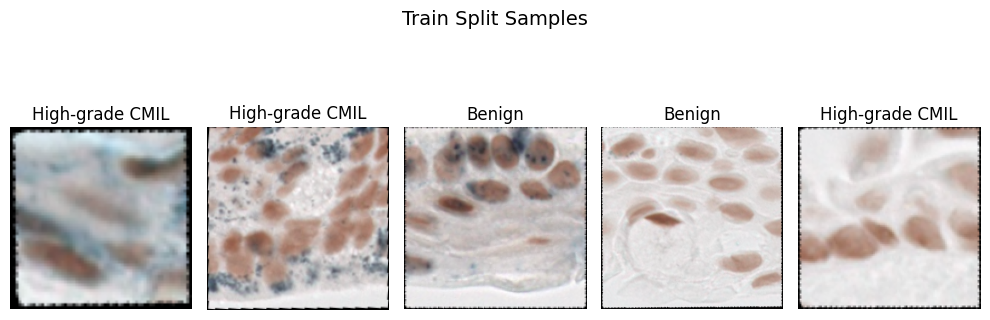


Train Set: Total Patches = 8141
  Benign (0):      3411
  High-grade (1):  4730

Validation Set: Total Patches = 3054
  Benign (0):      784
  High-grade (1):  2270

Test Set: Total Patches = 3416
  Benign (0):      666
  High-grade (1):  2750


In [ ]:
def visualize_random_samples(meta_df, title="Samples", n_samples=5, max_candidates=20, n_threads=5):
    """
    Efficiently sample & plot `n_samples` images by:
      - Sampling up to `max_candidates` rows
      - Loading in parallel (ThreadPoolExecutor of size `n_threads`)
      - Skipping unreadable files
    """
    # 1) pick up to max_candidates random rows
    sample_paths = meta_df.sample(
        n=min(max_candidates, len(meta_df)),
        random_state=42
    ).path.tolist()

    # 2) helper to try to open one image
    def try_load(path):
        try:
            img = Image.open(path).convert('RGB')
            arr = np.array(img) / 255.0
            return path, arr
        except Exception:
            return None

    # 3) load in parallel, stop once we have n_samples
    loaded = []
    with ThreadPoolExecutor(max_workers=n_threads) as exe:
        futures = { exe.submit(try_load, p): p for p in sample_paths }
        for fut in as_completed(futures):
            res = fut.result()
            if res:
                loaded.append(res)
            if len(loaded) >= n_samples:
                break

    if not loaded:
        print("⚠️  Could not load any sample images.")
        return

    # 4) plot however many we got (up to n_samples)
    n = len(loaded)
    fig, axes = plt.subplots(figsize=(10, 4), ncols=n)
    fig.suptitle(title, fontsize=14)
    for ax, (path, arr) in zip(axes, loaded):
        ax.imshow(arr)
        cid = int(case_pat.search(os.path.basename(path)).group(1))
        cls = "Benign" if labels_map[cid] == 0 else "High-grade CMIL"
        ax.set_title(cls)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Usage – should now be under 15 seconds:
visualize_random_samples(train_meta, title="Train Split Samples")

# ─── Step 10: Fast class-distribution counts ──────────────────────────────────
def print_meta_stats(name, meta_df):
    # count using metadata case_number → labels_map
    lbls = [ labels_map[cid] for cid in meta_df.case_number if cid in labels_map ]
    cnt = Counter(lbls)
    total = len(lbls)
    print(f"\n{name} Set: Total Patches = {total}")
    print(f"  Benign (0):      {cnt.get(0,0)}")
    print(f"  High-grade (1):  {cnt.get(1,0)}")

print_meta_stats("Train",      train_meta)
print_meta_stats("Validation", val_meta)
print_meta_stats("Test",       test_meta)


**8) Model Definition and Training**

**Define Generalized Model Traininng Function**

In [ ]:
import os
import torch
from torch.cuda.amp import autocast, GradScaler # Ensure autocast and GradScaler are imported
import matplotlib.pyplot as plt
from tqdm import tqdm
import subprocess
from torch import nn, optim # Ensure nn and optim are imported
from torchvision import models # Ensure models is imported for AlexNet
from collections import Counter # Ensure Counter is imported for class weights


In [ ]:

# Helper for moving batch to device (from your original code)
def move_batch_to_device(images, labels, device):
    """Moves a batch of images and labels to the specified device."""
    if isinstance(images, (list, tuple)):
        images = torch.stack([img.to(device, non_blocking=True) for img in images])
    else:
        images = images.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)
    return images, labels

# ─── Training Function (Updated for Gradient Accumulation and Mixed Precision) ───────────────────
def train_model(
        model,
        optimizer,
        criterion,
        train_loader,
        val_loader,
        epochs=3,
        scheduler=None,
        resume_from=None,
        device=None, # Changed default for better device handling
        final_model_save_path=None,
        accumulation_steps=1 # Parameter for gradient accumulation
    ):
    """
    Trains and evaluates a PyTorch model with gradient accumulation and mixed precision.

    Args:
        model (torch.nn.Module): The neural network model to train.
        optimizer (torch.optim.Optimizer): The optimizer for training.
        criterion (torch.nn.Module): The loss function.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        epochs (int, optional): Number of training epochs. Defaults to 3.
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate scheduler. Defaults to None.
        resume_from (str, optional): Path to a checkpoint file to resume training from. Defaults to None.
        device (torch.device, optional): The device to train on (e.g., 'cuda' or 'cpu').
                                          Defaults to None (auto-detects 'cuda' if available).
        final_model_save_path (str, optional): Path to save the final model weights after training completes.
                                                Defaults to None (no final save).
        accumulation_steps (int, optional): Number of batches to accumulate gradients over.
                                            Simulates a larger effective batch size. Defaults to 1 (no accumulation).
    Returns:
        torch.nn.Module: The trained model.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    torch.backends.cudnn.benchmark = True
    model.to(device)
    scaler = GradScaler() # Initialize GradScaler for mixed-precision training (if CUDA is used)
    model_dir = "/content/drive/MyDrive/sox10"
    os.makedirs(model_dir, exist_ok=True)

    best_acc = 0.0
    start_epoch = 0

    if resume_from and os.path.exists(resume_from):
        try:
            checkpoint = torch.load(resume_from, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch']
            best_acc = checkpoint.get('val_accuracy', 0.0)
            print(f"🔁 Resumed from checkpoint at epoch {start_epoch} with accuracy {best_acc:.4f}")
        except Exception as e:
            print(f"❌ Error loading checkpoint from {resume_from}: {e}. Starting training from scratch.")
            start_epoch = 0
            best_acc = 0.0

    train_losses, val_losses, val_accuracies = [], [], []

    for e in range(start_epoch, epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad() # Zero gradients at the start of each epoch

        train_bar = tqdm(train_loader, desc=f"Epoch {e+1}/{epochs}", leave=True)
        for i, batch in enumerate(train_bar): # Added index 'i' for gradient accumulation
            if batch[0] is None: # Skip empty batches
                continue
            images, labels, _ = batch
            images, labels = move_batch_to_device(images, labels, device)

            # --- Mixed Precision: Autocast for forward pass and loss calculation ---
            with autocast(enabled=(device.type == 'cuda')): # Only enable if device is CUDA
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss = loss / accumulation_steps # Scale the loss for gradient accumulation

            # --- Mixed Precision: Scaler for backward pass and optimizer step ---
            scaler.scale(loss).backward() # Scale loss and perform backward pass

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer) # Optimizer step with scaler
                scaler.update() # Update scaler
                optimizer.zero_grad() # Zero gradients after updating weights

            running_loss += loss.item() * accumulation_steps # Accumulate original loss value (unscaled)
            train_bar.set_postfix(loss=running_loss / (i + 1))

        # Handle any remaining accumulated gradients after the loop ends
        if (i + 1) % accumulation_steps != 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        if scheduler:
            # If using ReduceLROnPlateau, you might pass a metric: scheduler.step(avg_val_loss)
            scheduler.step()

        try:
            gpu_stats = subprocess.check_output([
                "nvidia-smi",
                "--query-gpu=utilization.gpu,utilization.memory,memory.used,memory.total",
                "--format=csv,nounits,noheader"
            ], stderr=subprocess.DEVNULL).decode("utf-8").strip()
            util, mem_util, used, total = [x.strip() for x in gpu_stats.split(',')]
            print(f"🔍 [GPU Util] GPU: {util}% | Mem: {mem_util}% ({used}/{total} MiB)")
        except Exception:
            print(f"🔍 [CUDA] Alloc: {torch.cuda.memory_allocated(device)/1024**2:.1f} MiB | "
                  f"Cached: {torch.cuda.memory_reserved(device)/1024**2:.1f} MiB")

        model.eval()
        validation_loss, correct, total_val_samples = 0.0, 0, 0

        with torch.no_grad():
            for batch in val_loader:
                if batch[0] is None:
                    continue
                images, labels, _ = batch
                images, labels = move_batch_to_device(images, labels, device)

                # --- Mixed Precision: Autocast for validation forward pass ---
                with autocast(enabled=(device.type == 'cuda')): # Only enable if device is CUDA
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                validation_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total_val_samples += labels.size(0)

        avg_val_loss = validation_loss / len(val_loader)
        val_accuracy = correct / total_val_samples if total_val_samples > 0 else 0.0
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(
            f"Epoch: {e+1}/{epochs}.. "
            f"Train Loss: {epoch_train_loss:.4f}.. "
            f"Val Loss: {avg_val_loss:.4f}.. "
            f"Val Accuracy: {val_accuracy:.4f}"
        )

        torch.save({
            'epoch': e + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_train_loss,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy
        }, os.path.join(model_dir, f"model_epoch_{e+1}.pth"))

        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_path = os.path.join(model_dir, "best_model.pth")
            torch.save(model.state_dict(), best_path)
            print(f"✅ New best model saved at epoch {e+1} with accuracy {val_accuracy:.4f}")

    # Plot
    epochs_range = list(range(start_epoch + 1, epochs + 1))
    if len(epochs_range) == len(train_losses) and len(epochs_range) > 0:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, train_losses, label='Training Loss')
        plt.plot(epochs_range, val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss During Training')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy During Training')
        plt.legend()

        plt.tight_layout()
        plt.show()
    else:
        print("Skipping plotting due to insufficient data or mismatch between epoch range and metric list lengths.")

    if final_model_save_path:
        os.makedirs(os.path.dirname(final_model_save_path), exist_ok=True)
        torch.save(model.state_dict(), final_model_save_path)
        print(f"🎉 Final model weights saved to: {final_model_save_path}")

    return model


**Define Your Model and Train**

You need to specify 5 things (Do not specify anything else - they are already specified in the config)

1) Define your model object
```
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT) # Use updated weights API
```
2) Unfreeze any layers that you want
```
for p in model.parameters(): p.requires_grad=False
```

3) Replace the classifier head if you want and modify feature extractor to include AdaptivePooling



```
# Modify feature extractor to include AdaptiveAvgPool2d
model.features = nn.Sequential(*list(model.features), nn.AdaptiveAvgPool2d((6, 6)))
in_ftrs = 256 * 6 * 6

# Custom classifier
model.classifier = nn.Sequential(
    nn.Dropout(), nn.Linear(in_ftrs, 4096), nn.ReLU(inplace=True),
    nn.Dropout(), nn.Linear(4096, 4096), nn.ReLU(inplace=True),
    nn.Linear(4096, 2)
)
```



4) Define the optimizer and pass your trainable parameters

```
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG["lr"]
)
```

5) Optional: Define your class weighting (for class imbalance) and update the criterion

```
from collections import Counter

def compute_class_weights(meta_df, labels_map):
    # Extract per‐patch labels
    lbls = [
        labels_map[int(cid)]
        for cid in meta_df.case_number
        if int(cid) in labels_map
    ]
    cnt = Counter(lbls)
    total = sum(cnt.values())
    # Inverse frequency: heavier weight for under-represented class
    w0 = total / cnt.get(0, 1)
    w1 = total / cnt.get(1, 1)
    return [w0, w1]

class_weights = compute_class_weights(train_meta, labels_map)

# Then your weighted‐loss setup becomes:
cw_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=cw_tensor)

```

If you are having trouble implementing this, plug-in these instructions and your model into ChatGPT.

In [ ]:
from torch.cuda.amp import autocast
from torch.utils.data import Dataset, DataLoader
import gc  # For garbage collection
# === Helper: Replace BatchNorm2d with GroupNorm ===
def replace_bn_with_gn(module, num_groups=32):
    for name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            num_channels = child.num_features
            setattr(module, name, nn.GroupNorm(num_groups=min(num_groups, num_channels), num_channels=num_channels))
        else:
            replace_bn_with_gn(child, num_groups=num_groups)

# === KimiaNet with GroupNorm ===
class KimiaNetClassifier(nn.Module):
    def __init__(self, num_classes=2, use_groupnorm=True):
        super(KimiaNetClassifier, self).__init__()
        base = models.densenet121(pretrained=False)

        if use_groupnorm:
            replace_bn_with_gn(base)

        self.features = base.features
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = F.relu(x, inplace=True)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        return self.classifier(x)

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KimiaNetClassifier(num_classes=2).to(device)

# Load weights (skip classifier mismatch)
state_dict = torch.load('/content/drive/MyDrive/KimiaNetPyTorchWeights.pth', map_location=device)
filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith('classifier')}
model.load_state_dict(filtered_state_dict, strict=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<ipython-input-22-5ef92eca61da>:51: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Initialize GradScaler for mixed-precision training (if CUDA is used)
Epoch 1/3:   0%|          | 0/4211 [00:00<?, ?it/s]<ipython-input-22-5ef92eca61da>:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')): # Only enable if device is CUDA
Epoch 1/3: 100%|██████████| 4211/4211 [17:45<00:00,  3.95it/s, loss=0.546]
<ipython-input-22-5ef92eca61da>:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')): # Only enable if device is CUDA


🔍 [GPU Util] GPU: 24% | Mem: 2% (859/40960 MiB)
Epoch: 1/3.. Train Loss: 0.5465.. Val Loss: 0.7384.. Val Accuracy: 0.6362
✅ New best model saved at epoch 1 with accuracy 0.6362


Epoch 2/3:   0%|          | 0/4211 [00:00<?, ?it/s]<ipython-input-22-5ef92eca61da>:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')): # Only enable if device is CUDA
Epoch 2/3: 100%|██████████| 4211/4211 [16:54<00:00,  4.15it/s, loss=0.435]
<ipython-input-22-5ef92eca61da>:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')): # Only enable if device is CUDA


🔍 [GPU Util] GPU: 24% | Mem: 2% (859/40960 MiB)
Epoch: 2/3.. Train Loss: 0.4345.. Val Loss: 0.8444.. Val Accuracy: 0.6156


Epoch 3/3:   0%|          | 0/4211 [00:00<?, ?it/s]<ipython-input-22-5ef92eca61da>:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')): # Only enable if device is CUDA
Epoch 3/3: 100%|██████████| 4211/4211 [16:46<00:00,  4.19it/s, loss=0.367]
<ipython-input-22-5ef92eca61da>:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')): # Only enable if device is CUDA


🔍 [GPU Util] GPU: 28% | Mem: 2% (859/40960 MiB)
Epoch: 3/3.. Train Loss: 0.3670.. Val Loss: 0.7719.. Val Accuracy: 0.6657
✅ New best model saved at epoch 3 with accuracy 0.6657


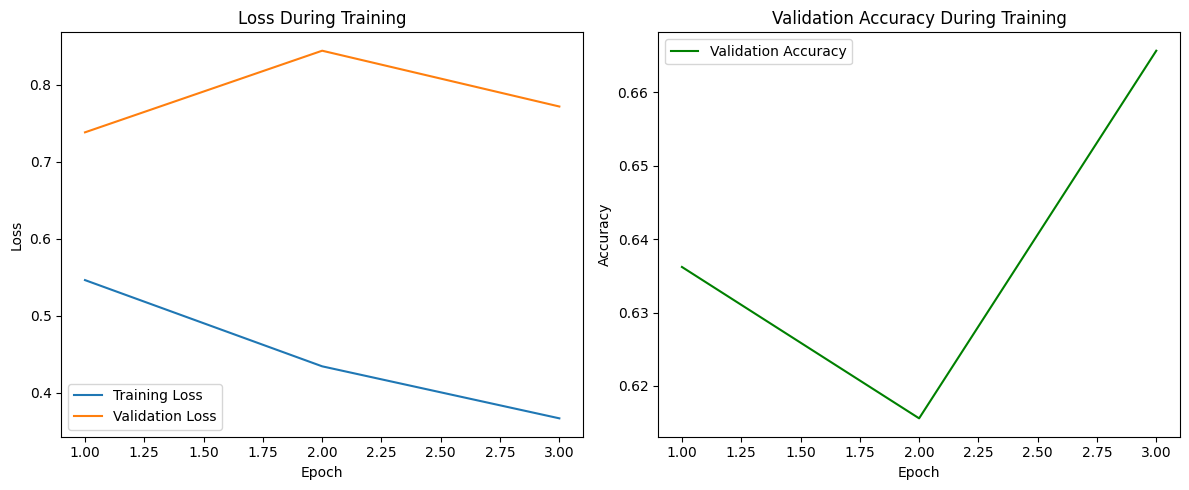

In [ ]:
# train model
trained_model = train_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=CONFIG['num_epochs'],
    scheduler=None,         # Optional: you can plug in a learning rate scheduler
    resume_from=None,       # Optional: provide path to checkpoint if resuming
    device=CONFIG['device'] # Uses GPU if available, otherwise CPU
)

<ipython-input-22-5ef92eca61da>:51: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Initialize GradScaler for mixed-precision training (if CUDA is used)


🔁 Resumed from checkpoint at epoch 3 with accuracy 0.6657


Epoch 4/5:   0%|          | 0/4211 [00:00<?, ?it/s]<ipython-input-22-5ef92eca61da>:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')): # Only enable if device is CUDA
Epoch 4/5: 100%|██████████| 4211/4211 [17:25<00:00,  4.03it/s, loss=0.314]
<ipython-input-22-5ef92eca61da>:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')): # Only enable if device is CUDA


🔍 [GPU Util] GPU: 17% | Mem: 1% (885/40960 MiB)
Epoch: 4/5.. Train Loss: 0.3141.. Val Loss: 0.6980.. Val Accuracy: 0.7115
✅ New best model saved at epoch 4 with accuracy 0.7115


Epoch 5/5:   0%|          | 0/4211 [00:00<?, ?it/s]<ipython-input-22-5ef92eca61da>:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')): # Only enable if device is CUDA
Epoch 5/5: 100%|██████████| 4211/4211 [16:52<00:00,  4.16it/s, loss=0.278]
<ipython-input-22-5ef92eca61da>:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')): # Only enable if device is CUDA


🔍 [GPU Util] GPU: 24% | Mem: 2% (885/40960 MiB)
Epoch: 5/5.. Train Loss: 0.2779.. Val Loss: 0.8011.. Val Accuracy: 0.6758


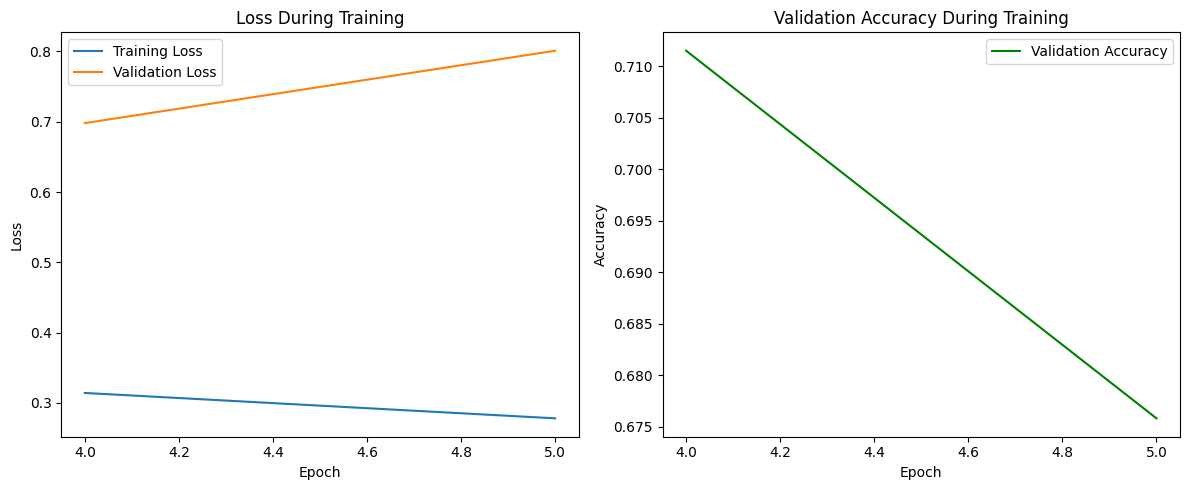

In [ ]:
trained_model = train_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=5,  # previously trained to 3 epochs, now going to 5 total
    scheduler=None,
    resume_from="/content/drive/MyDrive/sox10/model_epoch_3.pth",  # Update this if your last checkpoint is different
    device=CONFIG['device']
)

**9. Model Evaluation**


=== Test Set Performance ===
Accuracy      : 0.7067
Precision     : 0.9322
Recall        : 0.6855
F1 Score      : 0.7900

Classification Report:
                 precision    recall  f1-score   support

         Benign       0.38      0.79      0.51       666
High-grade CMIL       0.93      0.69      0.79      2750

       accuracy                           0.71      3416
      macro avg       0.66      0.74      0.65      3416
   weighted avg       0.82      0.71      0.74      3416



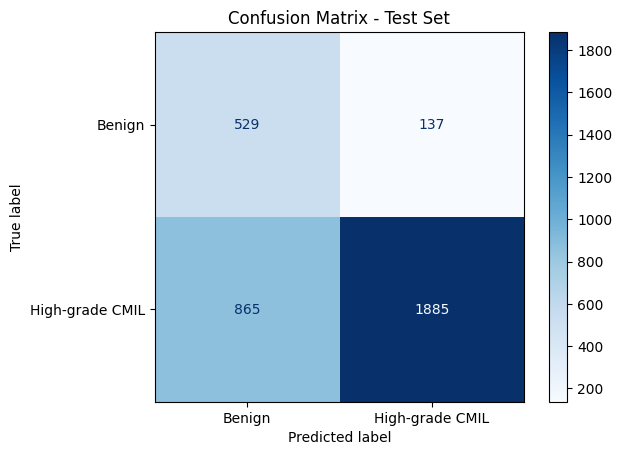

In [ ]:
def evaluate_model_on_test(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in test_loader:  # `_` = case IDs (optional)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # === Compute Metrics ===
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print("\n=== Test Set Performance ===")
    print(f"Accuracy      : {acc:.4f}")
    print(f"Precision     : {prec:.4f}")
    print(f"Recall        : {rec:.4f}")
    print(f"F1 Score      : {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Benign", "High-grade CMIL"]))

    # === Plot Confusion Matrix ===
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "High-grade CMIL"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix - Test Set")
    plt.show()

# === Run Evaluation ===
evaluate_model_on_test(trained_model, test_loader, CONFIG['device'])


**10. Patch Level to Case Level Prediction**

In [ ]:
# === STEP 1: Create labels_map from CSV with string labels ===
import pandas as pd
import torch

label_df = pd.read_csv("/content/drive/MyDrive/ML model comparison - Train-test split.csv")
class_map = {"Benign": 0, "High-grade": 1}
labels_map = {
    int(row.Case): class_map.get(row["class"], -1)  # Changed "class" to "Class"
    for _, row in label_df.iterrows()
}

# === STEP 2: Full case-level evaluation function ===
def evaluate_model_case_level_svc(
    model, df_train, df_test, train_loader, test_loader,
    labels_map, k=25, tune_svc=False, return_pred=False, device='cuda'
):
    from sklearn.svm import SVC, LinearSVC
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score,
        f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
    )
    import matplotlib.pyplot as plt

    model.eval()
    all_probs_tr, all_probs_tst = [], []

    with torch.no_grad():
        for images, _, _ in train_loader:
            images = images.to(device)
            probs = torch.nn.functional.softmax(model(images), dim=1)
            all_probs_tr.extend(probs.cpu().numpy())

        for images, _, _ in test_loader:
            images = images.to(device)
            probs = torch.nn.functional.softmax(model(images), dim=1)
            all_probs_tst.extend(probs.cpu().numpy())

    train_prob = [arr[0] for arr in all_probs_tr]
    test_prob = [arr[0] for arr in all_probs_tst]

    # === TRAIN SET ===
    df_train = df_train.copy()
    df_train['label'] = df_train['case_number'].map(labels_map)

    if df_train['stain'].nunique() > 1:
        idx = 0
        all_top_k = []
        for stain in df_train['stain'].unique():
            df_stain = df_train[df_train['stain'] == stain].reset_index(drop=True)
            stain_probs = train_prob[idx:idx + len(df_stain)]
            idx += len(df_stain)
            stain_top_k = pd.DataFrame({
                'case_number': df_stain.case_number.values,
                'prob': stain_probs
            }).groupby('case_number', group_keys=False).apply(
                lambda x: x.nlargest(k, columns='prob')
            ).reset_index(drop=True)
            stain_top_k['rank'] = stain_top_k.groupby('case_number').cumcount()
            stain_top_k = stain_top_k.pivot(index='case_number', columns='rank', values='prob').dropna()
            stain_top_k.columns = [f'{stain}_prob_{i}' for i in stain_top_k.columns]
            all_top_k.append(stain_top_k)
        top_k_prob = pd.concat(all_top_k, axis=1).dropna()
    else:
        top_k_prob = pd.DataFrame({
            'case_number': df_train.case_number.values,
            'prob': train_prob
        }).groupby('case_number', group_keys=False).apply(
            lambda x: x.nlargest(k, columns='prob')
        ).reset_index(drop=True)
        top_k_prob['rank'] = top_k_prob.groupby('case_number').cumcount()
        top_k_prob = top_k_prob.pivot(index='case_number', columns='rank', values='prob').dropna()

    case_label = df_train[df_train.case_number.isin(top_k_prob.index)] \
                    .groupby('case_number')['label'].first()

    # === Train SVC ===
    if tune_svc:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('svc', SVC())
        ])
        param_grid = [
            {'svc__kernel': ['linear'], 'svc__C': [0.01, 0.1, 1, 10, 100]},
            {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10], 'svc__gamma': ['scale', 0.01, 0.001, 0.0001]}
        ]
        svc = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
        svc.fit(top_k_prob, case_label)
        print("Selected parameters:", svc.best_params_)
    else:
        svc = make_pipeline(StandardScaler(), LinearSVC())
        svc.fit(top_k_prob, case_label)

    # === TEST SET ===
    df_test = df_test.copy()
    df_test['label'] = df_test['case_number'].map(labels_map)

    if df_train['stain'].nunique() > 1:
        idx = 0
        all_top_k = []
        for stain in df_train['stain'].unique():
            df_stain = df_test[df_test['stain'] == stain].reset_index(drop=True)
            stain_probs = test_prob[idx:idx + len(df_stain)]
            idx += len(df_stain)
            stain_top_k = pd.DataFrame({
                'case_number': df_stain.case_number.values,
                'prob': stain_probs
            }).groupby('case_number', group_keys=False).apply(
                lambda x: x.nlargest(k, columns='prob')
            ).reset_index(drop=True)
            stain_top_k['rank'] = stain_top_k.groupby('case_number').cumcount()
            stain_top_k = stain_top_k.pivot(index='case_number', columns='rank', values='prob').dropna()
            stain_top_k.columns = [f'{stain}_prob_{i}' for i in stain_top_k.columns]
            all_top_k.append(stain_top_k)
        top_k_prob_tst = pd.concat(all_top_k, axis=1).dropna()
    else:
        top_k_prob_tst = pd.DataFrame({
            'case_number': df_test.case_number.values,
            'prob': test_prob
        }).groupby('case_number', group_keys=False).apply(
            lambda x: x.nlargest(k, columns='prob')
        ).reset_index(drop=True)
        top_k_prob_tst['rank'] = top_k_prob_tst.groupby('case_number').cumcount()
        top_k_prob_tst = top_k_prob_tst.pivot(index='case_number', columns='rank', values='prob').dropna()

    case_label_tst = df_test[df_test.case_number.isin(top_k_prob_tst.index)] \
                        .groupby('case_number')['label'].first().fillna(-1)

    # === Handle missing labels ===
    missing = case_label_tst[case_label_tst == -1].index.tolist()
    if missing:
        print(f"⚠️ {len(missing)} test cases have missing labels and will be excluded from evaluation metrics.")
        print("Missing-label case numbers:", missing)

    # Predict on all test cases
    test_pred = svc.predict(top_k_prob_tst)

    # Filter for valid test cases for evaluation
    valid_mask = case_label_tst != -1
    case_label_eval = case_label_tst[valid_mask]
    test_pred_eval = test_pred[valid_mask]

    # === Metrics ===
    print("\n=== Train Set Performance ===")
    train_pred = svc.predict(top_k_prob)
    print(f"Accuracy:  {accuracy_score(case_label, train_pred):.4f}")
    print(f"Precision: {precision_score(case_label, train_pred):.4f}")
    print(f"Recall:    {recall_score(case_label, train_pred):.4f}")
    print(f"F1 Score:  {f1_score(case_label, train_pred):.4f}")

    print("\n=== Test Set Performance ===")
    print(f"Accuracy:  {accuracy_score(case_label_eval, test_pred_eval):.4f}")
    print(f"Precision: {precision_score(case_label_eval, test_pred_eval):.4f}")
    print(f"Recall:    {recall_score(case_label_eval, test_pred_eval):.4f}")
    print(f"F1 Score:  {f1_score(case_label_eval, test_pred_eval):.4f}")
    print("\nClassification Report:")
    print(classification_report(case_label_eval, test_pred_eval, target_names=["Benign", "High-grade CMIL"]))

    cm = confusion_matrix(case_label_eval, test_pred_eval)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.xticks([0, 1], ['Benign', 'High-grade CMIL'])
    plt.yticks([0, 1], ['Benign', 'High-grade CMIL'])
    plt.xlabel('Predicted Case Grade')
    plt.ylabel('Actual Case Grade')
    plt.title("Confusion Matrix - Test Set Case Level")
    plt.show()

    # === Predictions for missing-label cases ===
    if missing:
        print("\n🔍 Predictions for test cases with missing labels:")
        for cid, pred in zip(case_label_tst.index[~valid_mask], test_pred[~valid_mask]):
            label_str = "Benign" if pred == 0 else "High-grade CMIL"
            print(f"Case {cid}: predicted → {label_str}")

    if return_pred:
        return test_pred
    return None

# === Run Case-Level Model Evaluation ===
evaluate_model_case_level_svc(
    model, train_meta, test_meta, train_loader, test_loader,
    labels_map=labels_map, k=25, tune_svc=True
)


<ipython-input-26-ee15f45dfa1b>:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  }).groupby('case_number', group_keys=False).apply(


Selected parameters: {'svc__C': 0.01, 'svc__kernel': 'linear'}


ValueError: All arrays must be of the same length

**End of script – see below for other examples of correct model setups**

In [ ]:
# ─── 6) MODEL SETUP (KimiaNet) ───────────────────────────────────────────────

# 1) Define your model object (KimiaNet with Adaptive Pooling)
class KimiaNetClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(KimiaNetClassifier, self).__init__()
        base = models.densenet121(weights=None)  # No ImageNet weights
        self.features = base.features
        self.classifier = nn.Linear(1024, num_classes)  # DenseNet121 output is 1024-d

    def forward(self, x):
        x = self.features(x)
        x = nn.functional.relu(x, inplace=True)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        return self.classifier(x)

model = KimiaNetClassifier(num_classes=2) # only doing binary classification right now

# 2) Load pretrained KimiaNet weights and freeze backbone
kimianet_path = '/content/drive/MyDrive/Junior Year/STAT 390/KimiaNetPyTorchWeights.pth'  # 🔁 Update to your local path
state_dict = torch.load(kimianet_path, map_location='cpu')
filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith("classifier")}
model.load_state_dict(filtered_state_dict, strict=False)
print("✅ Loaded KimiaNet backbone weights")

for p in model.features.parameters():
    p.requires_grad = False  # Freeze feature extractor

# 3) (Already done above) Classifier head is defined as nn.Linear(1024, 2)

# 4) Define optimizer on trainable parameters
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG["lr"]
)

# 5) Optional class weights for imbalance
def compute_class_weights(meta_df, labels_map):
    lbls = [labels_map[int(cid)] for cid in meta_df.case_number if int(cid) in labels_map]
    cnt = Counter(lbls)
    total = sum(cnt.values())
    return [total / cnt.get(0, 1), total / cnt.get(1, 1)]

class_weights = compute_class_weights(train_meta, labels_map)
cw_tensor = torch.tensor(class_weights, dtype=torch.float32).to(CONFIG["device"])
criterion = nn.CrossEntropyLoss(weight=cw_tensor)

# Move model to device
model.to(CONFIG["device"])

✅ Loaded KimiaNet backbone weights


KimiaNetClassifier(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
trained_model = train_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=CONFIG['num_epochs'],s
    scheduler=None,
    resume_from=None,
    device=CONFIG['device']
)

Epoch 1/3:   0%|          | 0/80 [00:00<?, ?it/s]

In [ ]:
# ─── 7) MODEL SETUP (ResNET w/ CBAM) ───────────────────────────────────────────────

# 0) Define CBAM Components. Please change ratio and kernel_size to tune

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = 3 if kernel_size == 7 else 1
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv1(x))

class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(channels)
        self.sa = SpatialAttention()

    def forward(self, x):
        x = self.ca(x) * x
        x = self.sa(x) * x
        return x

class ResNetCBAM(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetCBAM, self).__init__()
        base = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.features = nn.Sequential(
            base.conv1,
            base.bn1,
            base.relu,
            base.maxpool,
            base.layer1,
            CBAM(256),
            base.layer2,
            CBAM(512),
            base.layer3,
            CBAM(1024),
            base.layer4,
            CBAM(2048),
            nn.AdaptiveAvgPool2d((6, 6))  # Match AlexNet-style output shape
        )
        in_ftrs = 2048 * 6 * 6
        self.classifier = nn.Sequential(
            nn.Dropout(), nn.Linear(in_ftrs, 4096), nn.ReLU(inplace=True),
            nn.Dropout(), nn.Linear(4096, 4096), nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


# 1) Define your model object
model = ResNetCBAM(num_classes=2)

# 2) Freeze pretrained layers
for p in model.parameters():
    p.requires_grad = False

# Optionally unfreeze the classifier
for p in model.classifier.parameters():
    p.requires_grad = True

# 3)  Feature extractor already includes AdaptiveAvgPool2d and custom classifier should already be set

# 4) Move model to device
device = CONFIG["device"]
model = model.to(device)

# Optimizer over only trainable parameters
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG["lr"]
)

# 5) Compute class weights for imbalance
def compute_class_weights(meta_df, labels_map):
    lbls = [labels_map[int(cid)] for cid in meta_df.case_number if int(cid) in labels_map]
    cnt = Counter(lbls)
    total = sum(cnt.values())
    return [total / cnt.get(0, 1), total / cnt.get(1, 1)]

class_weights = compute_class_weights(train_meta, labels_map)
cw_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=cw_tensor)